In [1]:
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import medmnist
from medmnist import INFO, Evaluator
from tqdm import tqdm
import numpy as np
import os
import hashlib
import urllib.request

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
data_flag = 'pathmnist'
download = True

epochs = 10
batch_size = 128
lr = 0.01

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])


    # ensure MedMNIST root exists and dataset file is present
medmnist_root = os.path.expanduser('~/.medmnist')
os.makedirs(medmnist_root, exist_ok=True)

# download the required npz if missing (will be placed under ~/.medmnist)
url = info.get('url')
expected_md5 = info.get('MD5')

if url is not None:
    fname = os.path.join(medmnist_root, os.path.basename(url.split('?')[0]))
    if not os.path.exists(fname):
        print(f"Downloading {os.path.basename(fname)} to {medmnist_root}")
        urllib.request.urlretrieve(url, fname)
        # verify md5 if available
    if expected_md5:
        with open(fname, 'rb') as f:
                md5 = hashlib.md5(f.read()).hexdigest()
        if md5 != expected_md5:
            raise RuntimeError(
                    f"MD5 mismatch for {fname}: expected {expected_md5}, got {md5}")

    # preprocessing
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])

    # load the data (we already ensured the npz file is present, so disable automatic download)
train_dataset = DataClass(
        split='train', transform=data_transform, download=False)
test_dataset = DataClass(
        split='test', transform=data_transform, download=False)

pil_dataset = DataClass(split='train', download=False)

    # encapsulate data into dataloader form
train_loader = data.DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)
train_loader_at_eval = data.DataLoader(
        dataset=train_dataset, batch_size=2*batch_size, shuffle=False)
test_loader = data.DataLoader(
        dataset=test_dataset, batch_size=2*batch_size, shuffle=False)

print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /home/syc/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-

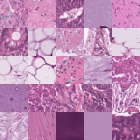

In [4]:
# Visualization
train_dataset.montage(length=5)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device, torch.cuda.get_device_name(0))

Device: cuda NVIDIA A100-SXM4-40GB


In [5]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
                nn.Conv2d(in_channels, 16, kernel_size=3),
                nn.BatchNorm2d(16),
                nn.ReLU())

        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 16, kernel_size=3),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
                nn.Conv2d(16, 64, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.ReLU())

        self.layer4 = nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.ReLU())

        self.layer5 = nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
                nn.Linear(64 * 4 * 4, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, num_classes))

    def forward(self, x):
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.layer5(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x

In [17]:
print('Begin Training:')
model = Net(in_channels=n_channels, num_classes=n_classes)
model.to(device)

if task == "multi-label, binary-class":
        criterion = nn.BCEWithLogitsLoss()
else:
        criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

best_auc = 0.0

# evaluation
def test(split, print_metrics=True):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            outputs = outputs.softmax(dim=-1).cpu()

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).cpu()
            else:
                targets = targets.squeeze().long().cpu()
                targets = targets.float().view(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
        if print_metrics:
            print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
        return metrics  # (auc, acc)

# train
for epoch in range(epochs):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    # Evaluate on test set and save best model
    auc, acc = test('test', print_metrics=False)
    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), 'baseline.pth')

print('Results:')
test('train')
test('test')

Begin Training:


 25%|██▍       | 174/704 [00:04<00:12, 43.06it/s]

100%|██████████| 704/704 [00:16<00:00, 42.92it/s]


Epoch [1/10], Loss: 0.4223


100%|██████████| 704/704 [00:16<00:00, 42.33it/s]


Epoch [2/10], Loss: 0.4214


100%|██████████| 704/704 [00:16<00:00, 43.57it/s]


Epoch [3/10], Loss: 0.3455


100%|██████████| 704/704 [00:16<00:00, 43.01it/s]


Epoch [4/10], Loss: 1.4375


100%|██████████| 704/704 [00:16<00:00, 43.10it/s]


Epoch [5/10], Loss: 0.5408


100%|██████████| 704/704 [00:16<00:00, 42.28it/s]


Epoch [6/10], Loss: 0.3578


100%|██████████| 704/704 [00:16<00:00, 43.32it/s]


Epoch [7/10], Loss: 0.0506


100%|██████████| 704/704 [00:16<00:00, 43.15it/s]


Epoch [8/10], Loss: 1.6083


100%|██████████| 704/704 [00:16<00:00, 42.32it/s]


Epoch [9/10], Loss: 0.5727


100%|██████████| 704/704 [00:16<00:00, 42.84it/s]


Epoch [10/10], Loss: 0.1238
Results:
train  auc: 0.999  acc:0.945
test  auc: 0.969  acc:0.833


Metrics(AUC=0.9685587909444173, ACC=0.8332869080779944)

Loading model from baseline.pth


Evaluating:  10%|█         | 3/29 [00:00<00:01, 22.41it/s]

Evaluating: 100%|██████████| 29/29 [00:01<00:00, 27.11it/s]


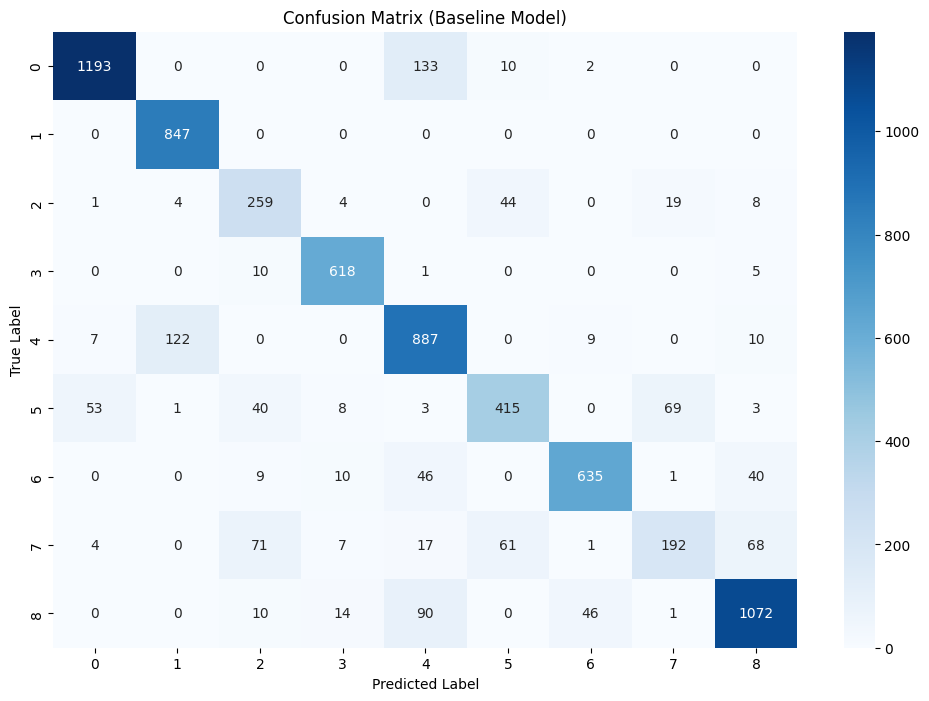

Macro-F1 Score: 0.8176

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9483    0.8916    0.9191      1338
           1     0.8696    1.0000    0.9303       847
           2     0.6491    0.7640    0.7019       339
           3     0.9349    0.9748    0.9544       634
           4     0.7536    0.8570    0.8020      1035
           5     0.7830    0.7010    0.7398       592
           6     0.9163    0.8570    0.8856       741
           7     0.6809    0.4561    0.5462       421
           8     0.8889    0.8694    0.8790      1233

    accuracy                         0.8521      7180
   macro avg     0.8250    0.8190    0.8176      7180
weighted avg     0.8528    0.8521    0.8494      7180



In [12]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

# Reload the best model from the progressive training stage
model_path = "baseline.pth"
print(f"Loading model from {model_path}")

model = Net(in_channels=n_channels, num_classes=n_classes)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

all_preds = []
all_targets = []

# Collect predictions and true labels
with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Evaluating"):
        x, y = x.to(device), y.to(device)
        # Handle potential one-hot encoding or extra dimensions
        if len(y.shape) > 1 and y.shape[1] > 1:
            y = y.argmax(dim=1)
        
        outputs = model(x)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.squeeze().cpu().numpy())

# 1. Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Baseline Model)')
plt.show()

# 2. Macro-F1 Score
macro_f1 = f1_score(all_targets, all_preds, average='macro')
print(f"Macro-F1 Score: {macro_f1:.4f}")

# Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(all_targets, all_preds, digits=4))